In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = 'data/dogbreeds/'

In [120]:
sz=220

### Load Data

In [7]:
df = pd.read_csv(PATH+'labels.csv')

In [8]:
df.columns

Index(['id', 'breed'], dtype='object')

In [29]:
df['id'].size

10222

data/dogbreeds/train/000bec180eb18c7604dcecc8fe0dba07.jpg


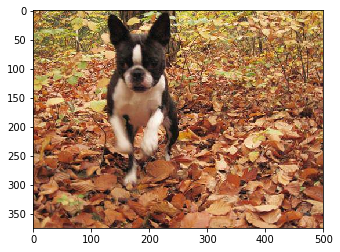

In [17]:
test_file = PATH+'train/'+df['id'][0]+'.jpg'
print(test_file)
test_img = plt.imread(test_file)
plt.imshow(test_img)
# PIL.Image.open(test_file)

In [68]:
size_map = { k:plt.imread(f'{PATH}train/{k}.jpg').shape for k in df['id'][1:]}

In [71]:
size_map

{'001513dfcb2ffafc82cccf4d8bbaba97': (375, 500, 3),
 '001cdf01b096e06d78e9e5112d419397': (375, 500, 3),
 '00214f311d5d2247d5dfe4fe24b2303d': (344, 400, 3),
 '0021f9ceb3235effd7fcde7f7538ed62': (500, 500, 3),
 '002211c81b498ef88e1b40b9abf84e1d': (375, 500, 3),
 '00290d3e1fdd27226ba27a8ce248ce85': (470, 500, 3),
 '002a283a315af96eaea0e28e7163b21b': (227, 231, 3),
 '003df8b8a8b05244b1d920bb6cf451f9': (500, 474, 3),
 '0042188c895a2f14ef64a918ed9c7b64': (332, 500, 3),
 '004396df1acd0f1247b740ca2b14616e': (500, 375, 3),
 '0067dc3eab0b3c3ef0439477624d85d6': (343, 402, 3),
 '00693b8bc2470375cc744a6391d397ec': (299, 500, 3),
 '006cc3ddb9dc1bd827479569fcdc52dc': (223, 250, 3),
 '0075dc49dab4024d12fafe67074d8a81': (332, 500, 3),
 '00792e341f3c6eb33663e415d0715370': (192, 200, 3),
 '007b5a16db9d9ff9d7ad39982703e429': (212, 374, 3),
 '007b8a07882822475a4ce6581e70b1f8': (500, 333, 3),
 '007ff9a78eba2aebb558afea3a51c469': (375, 500, 3),
 '008887054b18ba3c7601792b6a453cc3': (160, 160, 3),
 '008b1271ed

In [73]:
h, w, ch = list(zip(*size_map.values()))

(array([3798., 6258.,  108.,   18.,   11.,    4.,   19.,    2.,    1.,    2.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

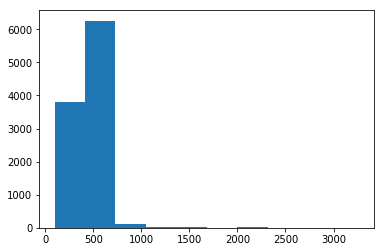

In [74]:
plt.hist(w)

(array([  36.,  197.,  438.,  409., 1158., 1251.,  499.,  365., 5449.,   62.]),
 array([ 97. , 147.1, 197.2, 247.3, 297.4, 347.5, 397.6, 447.7, 497.8, 547.9, 598. ]),
 <a list of 10 Patch objects>)

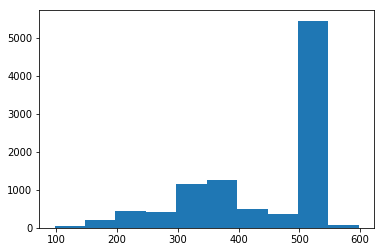

In [77]:
w = np.array(w)
plt.hist(w[w<600])

### Architecture

In [121]:
!rm -rf {PATH}tmp

In [122]:
arch=resnet34

In [123]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
n = df['id'].size-1
val_idxs = get_cv_idxs(n)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=f'{PATH}labels.csv', test_name='test', tfms=tfms, suffix='.jpg', val_idxs=val_idxs)
new_data = data.resize(sz, 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [124]:
learn = ConvLearner.pretrained(arch, data=new_data, precompute=True)

100%|██████████| 162/162 [00:18<00:00,  8.79it/s]


In [125]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 112/128 [00:01<00:00, 77.63it/s, loss=14.5]


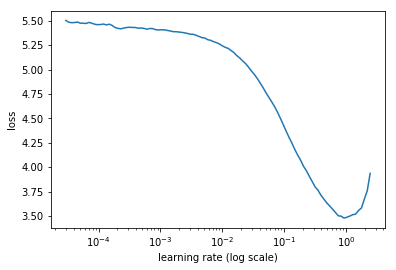

In [126]:
learn.sched.plot()

In [127]:
learn.fit(lrs=1e-1, n_cycle=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[0.      1.31655 0.80036 0.76029]                           
[1.      0.86391 0.75824 0.79509]                            



In [128]:
learn.fit(lrs=1e-2, n_cycle=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[0.      0.51683 0.64921 0.81471]                           
[1.      0.45434 0.6889  0.81667]                            



In [129]:
learn.precompute=False

In [130]:
learn.fit(lrs=1e-2, n_cycle=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.62556 0.57559 0.82148]                            
[1.      0.60999 0.57319 0.82396]                            
[2.      0.58847 0.56598 0.82396]                            



In [131]:
learn.unfreeze()

In [132]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▌  | 96/128 [00:33<00:11,  2.90it/s, loss=3.12] 

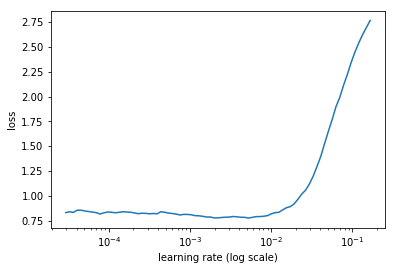

In [133]:
learn.sched.plot()

In [134]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 13%|█▎        | 17/128 [00:06<00:41,  2.67it/s, loss=0.816]


Exception in thread Thread-99:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[0.      0.67599 0.659   0.79609]                            
[1.      0.60169 0.65986 0.79515]                            
[2.      0.51699 0.6222  0.81172]                            



In [135]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.51837 0.66465 0.79411]                            
[1.      0.46859 0.63709 0.79847]                            
[2.      0.3692  0.62495 0.81224]                            
[3.      0.33589 0.65477 0.80238]                            
[4.      0.3096  0.65339 0.8068 ]                            
  2%|▏         | 2/128 [00:01<01:09,  1.82it/s, loss=0.308]

KeyboardInterrupt: 

In [136]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds,y), metrics.log_loss(y, probs)

AttributeError: 'bool' object has no attribute 'mean'

In [146]:
preds = np.argmax(log_preds, axis=1)
# np.array(preds==y).mean()
preds
# accuracy(log_preds,y)

array([[ 666, 1637, 1058, 1427,  222, 1070,  725, 1681,  821, 1088,  364,  113,  330,  479,   88, 1347,
        1396,  620, 1727, 1734,  762, 1096,   39,  746, 1831, 1023,   36, 2017, 1187,  328, 1195, 2007,
        1753, 1044,  391,  798,  926, 1986, 1467, 1261,  642, 1237,   22, 1149, 1042,  745,  179,  460,
         362,   14, 1668, 2041, 1469, 1000,  184,  428, 1200, 1013,  548,  648,  938,  452, 1423,  349,
         963,   82,  998, 1952, 1011, 1693,  615,  234,  466,  848, 1098,  659, 1020, 1599,  867,  787,
        1517,  920,  378, 2035, 1710, 1112,  583,   74, 1126, 1063,  275, 1552,  603,  366, 2009, 1291,
        1335,  566, 1387, 2018, 1495,  497, 1931, 1483,  845,  836, 1618,  828, 1265,  190, 1229, 1990,
        1412, 1647,  816, 1188,  997, 1664,  872, 1872],
       [1961, 1170,  759, 1427, 1243, 1070, 1144,  756,  821, 1088,  364, 1862,  330,  320,  253, 1799,
        2020, 1169, 1727, 1734,  762,  439,   39,  746,  716,  346,   38, 2017,  556,  328, 1195,  332,
       